In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, precision_score, recall_score, f1_score

## Pré-processamento

In [38]:
true = pd.read_csv('noticias/true.csv')
true_2 = pd.read_csv('noticias/true_news.csv')
fake = pd.read_csv('noticias/fake.csv')
news = pd.concat([true, fake, true_2],axis=0, ignore_index=True)
news.head()

,title,text,origin,url,label,publisher_name,publisher_site,date
0,Jovem Pan: o que é falso e o que é verdadeiro ...,As propostas de manter zerados impostos federa...,Jair Bolsonaro,https://lupa.uol.com.br/jornalismo/2022/09/06/...,0,Lupa - UOL,lupa.uol.com.br,NaN
1,Jovem Pan: o que é falso e o que é verdadeiro ...,Estatais dão lucro de mais de R$ 100 bilhões e...,Jair Bolsonaro,https://lupa.uol.com.br/jornalismo/2022/09/06/...,0,Lupa - UOL,lupa.uol.com.br,NaN
2,De cargos secretos a segurança: veja erros e a...,A água foi privatizada. A Cedae não acabou. Es...,Marcelo Freixo (PSB),https://lupa.uol.com.br/jornalismo/2022/09/01/...,0,Lupa - UOL,lupa.uol.com.br,NaN
3,De cargos secretos a segurança: veja erros e a...,São quase 3 milhões de pessoas passando fome [...,Marcelo Freixo (PSB),https://lupa.uol.com.br/jornalismo/2022/09/01/...,0,Lupa - UOL,lupa.uol.com.br,NaN
4,De cargos secretos a segurança: veja erros e a...,[Cláudio Castro] tem pouco mais de 20% de ótim...,Marcelo Freixo (PSB),https://lupa.uol.com.br/jornalismo/2022/09/01/...,0,Lupa - UOL,lupa.uol.com.br,NaN


In [39]:
news.tail()

,title,text,origin,url,label,publisher_name,publisher_site,date
39821,NaN,A bandeira tarifária que será aplicada nas con...,NaN,NaN,0,NaN,NaN,NaN
39822,NaN,O presidente da Associação Brasileira da Indús...,NaN,NaN,0,NaN,NaN,NaN
39823,NaN,"Policiais militares, com apoio da Polícia Civi...",NaN,NaN,0,NaN,NaN,NaN
39824,NaN,EDUARDO SODRÉ COLUNISTA DA FOLHA O mercado au...,NaN,NaN,0,NaN,NaN,NaN
39825,NaN,A Comissão Interamericana de Direitos Humanos ...,NaN,NaN,0,NaN,NaN,NaN


In [40]:
news.drop(['title','url','publisher_site', 'origin', 'publisher_name', 'date'], axis=1, inplace=True)
news

,text,label
0,As propostas de manter zerados impostos federa...,0
1,Estatais dão lucro de mais de R$ 100 bilhões e...,0
2,A água foi privatizada. A Cedae não acabou. Es...,0
3,São quase 3 milhões de pessoas passando fome [...,0
4,[Cláudio Castro] tem pouco mais de 20% de ótim...,0
...,...,...
39821,A bandeira tarifária que será aplicada nas con...,0
39822,O presidente da Associação Brasileira da Indús...,0
39823,"Policiais militares, com apoio da Polícia Civi...",0
39824,EDUARDO SODRÉ COLUNISTA DA FOLHA O mercado au...,0


In [41]:
news.isna().sum()

text     0
label    0
dtype: int64

In [42]:
#true=0,fake=1 to true=1, fake=0
news['label'] = news['label'].apply(lambda x: 1 if x == 0 else 0)

In [43]:
news['label'].unique() 

array([1, 0])

<Axes: xlabel='label', ylabel='count'>

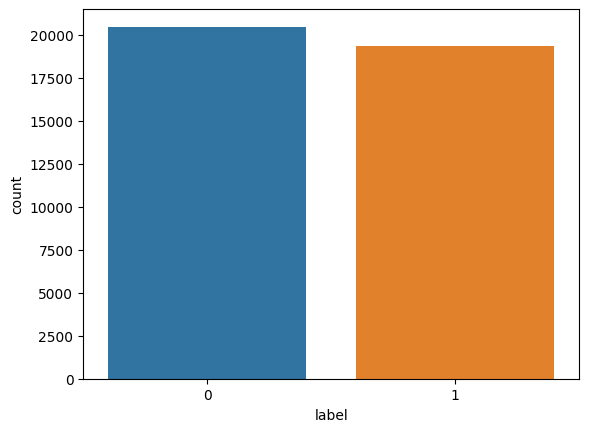

In [44]:
sns.countplot(x='label', data=news)

In [45]:
news = news.sample(frac=1, random_state=1).reset_index(drop=True)
news

,text,label
0,3 milhões de votos aparecem de forma inexplicá...,0
1,O ‘problema’ com a hidroxicloroquina é que ela...,0
2,Music-Check. “Born in the USA” foi o primeiro ...,1
3,A bagagem de mão pode ser maior do que antes,1
4,Desfile militar com tanques em Brasília em 10 ...,0
...,...,...
39821,Presidente do Comitê Organizador da Copa do Mu...,0
39822,"Mahershala Ali, vencedor do Oscar de melhor at...",1
39823,Eu estou achando uma dificuldade. A gente não ...,0
39824,Menina de 10 anos em Lençois Paulista teve par...,0


In [46]:
def text_cleaning(text):
  text = text.lower()

  text = re.sub(r'[^\w\s]', '', text) #Remover pontuação

  text = re.sub(r'[\d]', '', text) #Remover digitos

  text = re.sub(r'https?://S+|www\.\S+', '', text) #Remover URLs

  return text

In [47]:
news['text'] = news['text'].apply(text_cleaning)
news

,text,label
0,milhões de votos aparecem de forma inexplicáv...,0
1,o problema com a hidroxicloroquina é que ela t...,0
2,musiccheck born in the usa foi o primeiro cd f...,1
3,a bagagem de mão pode ser maior do que antes,1
4,desfile militar com tanques em brasília em de...,0
...,...,...
39821,presidente do comitê organizador da copa do mu...,0
39822,mahershala ali vencedor do oscar de melhor ato...,1
39823,eu estou achando uma dificuldade a gente não t...,0
39824,menina de anos em lençois paulista teve parad...,0


## Modelagem e treinamento

In [48]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False, clean_up_tokenization_spaces=True)
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
noticias = news['text'].tolist() 
rotulo = news['label'].tolist()

In [50]:
encodings = tokenizer(noticias, truncation=True, padding=True, max_length=128, return_tensors='pt')
labels = torch.tensor(rotulo).clone().detach()
print(len(encodings['input_ids']), len(labels))

39826 39826


In [51]:
x_train, x_test, y_train, y_test, mask_train, mask_test = train_test_split(encodings['input_ids'], labels, encodings['attention_mask'], test_size=0.2, random_state=1)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([31860, 128]) torch.Size([31860]) torch.Size([7966, 128]) torch.Size([7966])


In [52]:
class createDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        item = {key: self.encodings[key][index] for key in self.encodings}
        item['labels'] = self.labels[index].clone().detach()
        return item

In [53]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision_score(p.label_ids, preds),
        'recall': recall_score(p.label_ids, preds),
        'f1-score': f1_score(p.label_ids, preds)
    }

In [54]:
train_encodings = {'input_ids': x_train, 'attention_mask': mask_train}
test_encodings = {'input_ids': x_test, 'attention_mask': mask_test}

train_dataset = createDataset(train_encodings, y_train)
test_dataset = createDataset(test_encodings, y_test)

In [55]:
'''
weight_decay=0.01,                
logging_dir='./logs',                              
save_steps=500,                   
save_total_limit=2,               
metric_for_best_model="precision",
seed=1, '''

'\n '

In [58]:
training_args = TrainingArguments(output_dir='./results', 
                                  evaluation_strategy='epoch',
                                  num_train_epochs= 3,
                                  report_to="none")

trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics
                 )

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,0.217800,0.223751,0.928697,0.988323,0.861880,0.920781
2,0.163100,0.220957,0.927693,0.956510,0.890078,0.922099
3,0.119500,0.260463,0.924052,0.944093,0.895039,0.918912


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=5976, training_loss=0.162133615179713, metrics={'train_runtime': 1898.5533, 'train_samples_per_second': 50.344, 'train_steps_per_second': 3.148, 'total_flos': 6287038667827200.0, 'train_loss': 0.162133615179713, 'epoch': 3.0})

## Avaliação

In [60]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.26046282052993774,
 'eval_accuracy': 0.9240522219432589,
 'eval_precision': 0.9440925364913247,
 'eval_recall': 0.8950391644908616,
 'eval_f1-score': 0.9189116740383327,
 'eval_runtime': 45.2186,
 'eval_samples_per_second': 176.167,
 'eval_steps_per_second': 11.013,
 'epoch': 3.0}

In [61]:
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json')

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4136
           1       0.94      0.90      0.92      3830

    accuracy                           0.92      7966
   macro avg       0.93      0.92      0.92      7966
weighted avg       0.92      0.92      0.92      7966

0.9240522219432589


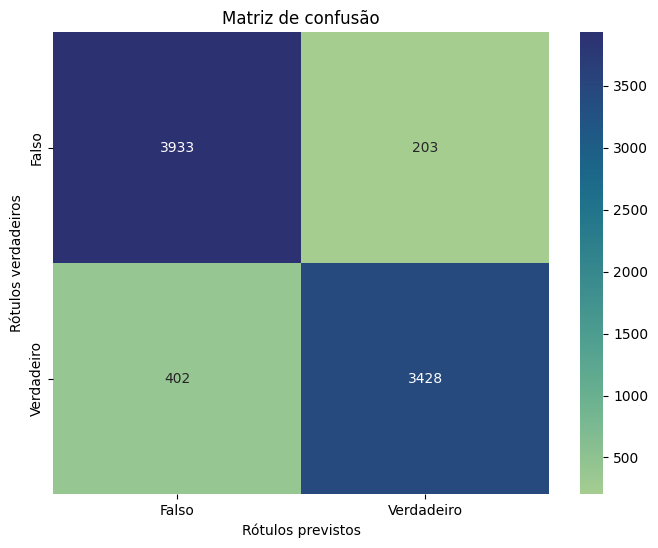

In [62]:
true_labels = []
pred_labels = []

model.eval()

validation_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    for i in validation_dataloader:
        
        inputs = {key: val.to(device) for key, val in i.items()}

        labels = inputs.pop('labels').to('cpu').numpy()

        outputs = model(**inputs)

        preds = torch.argmax(outputs.logits, dim=1).to('cpu').numpy()

        true_labels.extend(labels)
        pred_labels.extend(preds)

cm = confusion_matrix(true_labels, pred_labels)
print(classification_report(true_labels, pred_labels))
bert_accuracy = accuracy_score(true_labels, pred_labels)
print(bert_accuracy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=True) 
plt.xlabel('Rótulos previstos')
plt.ylabel('Rótulos verdadeiros')
plt.title('Matriz de confusão')
plt.xticks([0.5, 1.5], ['Falso', 'Verdadeiro']) 
plt.yticks([0.5, 1.5], ['Falso', 'Verdadeiro'])
plt.savefig('matriz-conf.png')
plt.show()

In [ ]:
def predict(text):
    
    inputs = tokenizer(text, return_tensors='pt')
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return ("Verdadeiro" if prediction == 1 else "Falso")

In [ ]:
print(predict("O novo estudo afirma que a lua é feita de queijo."))

In [ ]:
print(predict('A fumaça das queimadas que tem encoberto cidades do Norte, Centro-Oeste, Sudeste e Sul do país causa preocupação não só entre ambientalistas, mas também entre médicos e especialistas em saúde.'))

In [ ]:
from transformers import BertForPreTraining
modelo_base = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased')
modelo_treinado = BertForSequenceClassification.from_pretrained('./trained_model')

In [ ]:
trainer_base = Trainer(
    model=modelo_base,
    args=training_args,
    compute_metrics=compute_metrics,
    eval_dataset=test_dataset
)
result_base = trainer_base.evaluate()

In [ ]:
trainer_treinado = Trainer(
    model=modelo_treinado,
    args=training_args,
    compute_metrics=compute_metrics,
    eval_dataset=test_dataset
)
result_treinado = trainer_treinado.evaluate()

In [ ]:
print("Modelo Base:", result_base)
print("Modelo Treinado em Notícias Falsas:", result_treinado)

In [ ]:
result_base = {
    'accuracy': result_base['eval_accuracy'],
    'precision': result_base['eval_precision'],
    'recall': result_base['eval_recall'],
    'f1': result_base['eval_f1-score']
}

result_treinado = {
    'Accuracy': result_treinado['eval_accuracy'],
    'Precision': result_treinado['eval_precision'],
    'Recall': result_treinado['eval_recall'],
    'F1-score': result_treinado['eval_f1-score']
}

In [ ]:
metrics = metrics = ["Acurácia", "Precisão", "Revocação", "F1-Score"]
values_base = list(result_base.values())
values_treinado = list(result_treinado.values())

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
bar1 = ax.bar(x - width/2, values_base, width, label='Modelo Base', color='royalblue')
bar2 = ax.bar(x + width/2, values_treinado, width, label='Modelo Treinado', color='seagreen')

ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação entre os Modelos')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='upper left', bbox_to_anchor=(-0.1, 1))

for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

for bar in bar2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')


plt.tight_layout()
plt.savefig('comp-modelos.png')
plt.show()

In [ ]:
true_labels = []
pred_labels = []

model.eval()

validation_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    for i in validation_dataloader:
        
        inputs = {key: val.to(device) for key, val in i.items()}

        labels = inputs.pop('labels').to('cpu').numpy()

        outputs = modelo_base(**inputs)

        preds = torch.argmax(outputs.logits, dim=1).to('cpu').numpy()

        true_labels.extend(labels)
        pred_labels.extend(preds)

cm = confusion_matrix(true_labels, pred_labels)
print(classification_report(true_labels, pred_labels))
bert_accuracy = accuracy_score(true_labels, pred_labels)
print(bert_accuracy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=True) 
plt.xlabel('Rótulos previstos')
plt.ylabel('Rótulos verdadeiros')
plt.title('Matriz de confusão')
plt.xticks([0.5, 1.5], ['Falso', 'Verdadeiro']) 
plt.yticks([0.5, 1.5], ['Falso', 'Verdadeiro'])
plt.savefig('matriz-conf.png')
plt.show()